In [1]:
pip install --upgrade numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 96.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xmip 0.7.2 requires cf_xarray>=0.6.0, which is not installed.
xmip 0.7.2 requires xarrayutils, which is not installed.
xmip 0.7.2 requires xgcm<0.7.0, which is not installed.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext autoreload
%autoreload 2

import dask
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial
import cartopy
import cartopy.crs as ccrs
import pymc as pm
import arviz as az
import pickle
import cloudpickle

from normalization_utils import combo_scaler, inverse_combo_scaler

### Bring in the Grounded Model

In [2]:
model_pickle_path, gridded_inputs_path, ice_sheet = (
    "outputs/cresis_gis_grounded_model.pickle",
    "../data_preprocessing/input_data_gis.nc",
    'greenland'
)

In [3]:
pred_inputs = xr.open_dataset(gridded_inputs_path)

with open(model_pickle_path, "rb") as f:
    training_results = cloudpickle.load(f)

ModuleNotFoundError: No module named 'pathlib._local'; 'pathlib' is not a package

In [4]:
pred_inputs

<xarray.Dataset> Size: 151MB
Dimensions:    (y: 3058, x: 1703)
Coordinates:
  * x          (x) int32 7kB -652925 -652025 -651125 ... 877075 877975 878875
  * y          (y) int32 12kB -632675 -633575 -634475 ... -3383075 -3383975
Data variables:
    thickness  (y, x) float32 21MB ...
    errbed     (y, x) float32 21MB ...
    mask       (y, x) int8 5MB ...
    surface    (y, x) float32 21MB ...
    speed      (y, x) float32 21MB ...
    speed_err  (y, x) float32 21MB ...
    t2m        (y, x) float32 21MB ...
    t2m_err    (y, x) float32 21MB ...
Attributes: (12/16)
    Conventions:                 CF-1.7
    Title:                       BedMachine Greenland
    Author:                      Mathieu Morlighem
    version:                     28-Jul-2022 (v5.5)
    nx:                          10218.0
    ny:                          18346.0
    ...                          ...
    xmin:                        -652925
    ymax:                        -632675
    spacing:                     150
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2017), BedMachine v3: ...

In [5]:
training_results.keys()

dict_keys(['dataset_name', 'ice_sheet', 'bm_mask_whitelist', 'input_data_path', 'trace', 'model', 'normalization_parameters'])

In [6]:
# Normalize inputs

norm_params = training_results['normalization_parameters']

for var in norm_params:
    if var in pred_inputs.data_vars:
        pred_inputs[var + "_norm"] = combo_scaler(pred_inputs[var], norm_params[var])

In [7]:
posterior = az.extract(training_results['trace'])
posterior_quantiles = posterior.quantile([0.025, 0.5, 0.975])

def predict(quantile):
    res_norm = (
        posterior_quantiles['intercept'].sel(quantile=quantile).values +
        posterior_quantiles['beta_thickness'].sel(quantile=quantile).values * pred_inputs['thickness_norm'] +
        posterior_quantiles['beta_surface_temp'].sel(quantile=quantile).values * pred_inputs['t2m_norm'] +
        posterior_quantiles['beta_surface_elev'].sel(quantile=quantile).values * pred_inputs['surface_norm']
    )
    return inverse_combo_scaler(res_norm, norm_params['snr'])

median_rssnr = predict(0.5)
ci_low_rssnr = predict(0.025)
ci_high_rssnr = predict(0.975)

In [8]:
# Mask results to relevant locations

mask = (pred_inputs['mask'].isin(training_results['bm_mask_whitelist'])) & (pred_inputs['thickness'] > 100)

# Set median_rssnr to np.nan based on mask
median_rssnr_masked = median_rssnr.where(mask)
ci_low_rssnr_masked = ci_low_rssnr.where(mask)
ci_high_rssnr_masked = ci_high_rssnr.where(mask)

# Create a velocity array of the same length
velocity_masked = pred_inputs['speed'].where(mask)

### Plot results

In [9]:
# Map projections for plotting
crs_3031 = cartopy.crs.Stereographic(central_latitude=-90, true_scale_latitude=-71) # All Antarctic data will be projected (if needed) to this
crs_3413 = ccrs.Stereographic(central_latitude=90, central_longitude=-45, true_scale_latitude=70) # All Greenland data will be projected (if needed) to this
crs_lonlat = cartopy.crs.PlateCarree()

if ice_sheet == 'antarctica':
    projection = crs_3031
    crs_name = "EPSG:3031"
elif ice_sheet == 'greenland':
    projection = crs_3413
    crs_name = "EPSG:3413"
else:
    raise ValueError('ice_sheet must be either "greenland" or "antarctica"')

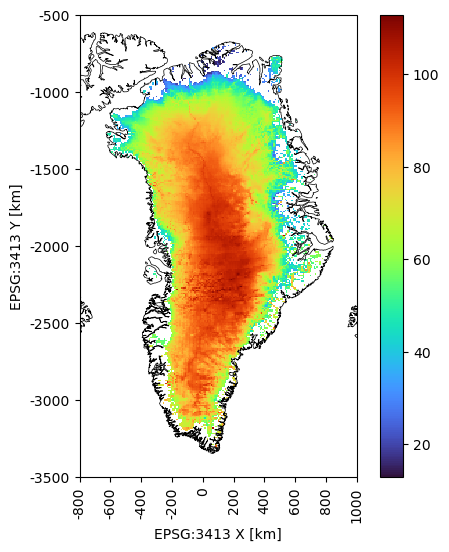

In [10]:
# Map of median predicted RSSNR
fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(projection=projection))

cmap='turbo'
decimation_for_plotting = 10

median_rssnr_masked[::decimation_for_plotting, ::decimation_for_plotting].plot.pcolormesh(ax=ax, cmap=cmap)
ax.coastlines(resolution='10m', color='black', linewidth=0.5)

# Axes
ax.set_xlabel(f'{crs_name} X [km]')
ax.set_ylabel(f'{crs_name} Y [km]')
ax.set_xticks(ax.get_xticks(), crs=projection)
ax.set_yticks(ax.get_yticks(), crs=projection)
ax.tick_params(axis='x', rotation=90)
# Show axis ticks in kilometers
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:.0f}'))

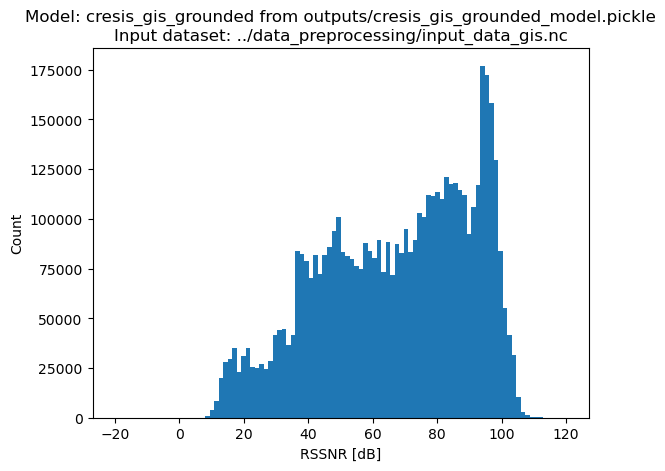

In [11]:
fig, ax = plt.subplots()
#median_rssnr_masked.plot.hist(bins=100, range=[-20, 120], ax=ax)
median_rssnr.plot.hist(bins=100, range=[-20, 120], ax=ax)
ax.set_xlabel('RSSNR [dB]')
ax.set_ylabel('Count')
ax.set_title(f'Model: {training_results["dataset_name"]} from {model_pickle_path}\nInput dataset: {gridded_inputs_path}')
fig.show()

In [5]:
def cdf_variable_maker(median_rssnr, low_rssnr, high_rssnr):
    
    # Sort the data
    sorted_idxs = np.argsort(median_rssnr.values.flatten())
    sorted_median = median_rssnr.values.flatten()[sorted_idxs]

    # Calculate the CDF values
    cdf_values = np.arange(1, len(sorted_median) + 1) / len(sorted_median)

    shifted_low_rssnr = low_rssnr-9.5
    shifted_high_rssnr = high_rssnr+9.5

    return sorted_median, cdf_values, shifted_low_rssnr, shifted_high_rssnr

In [ ]:
# Create fast and low velocities
median_rssnr_fast = median_rssnr_masked.where(velocity_masked>50)
ci_low_rssnr_fast = ci_low_rssnr_masked.where(velocity_masked>50)
ci_high_rssnr_fast = cci_high_rssnr_masked.where(velocity_masked>50)

median_rssnr_slow = median_rssnr_masked.where(velocity_masked<=50)
ci_low_rssnr_slow = ci_low_rssnr_masked.where(velocity_masked<=50)
ci_high_rssnr_slow = cci_high_rssnr_masked.where(velocity_masked<=50)

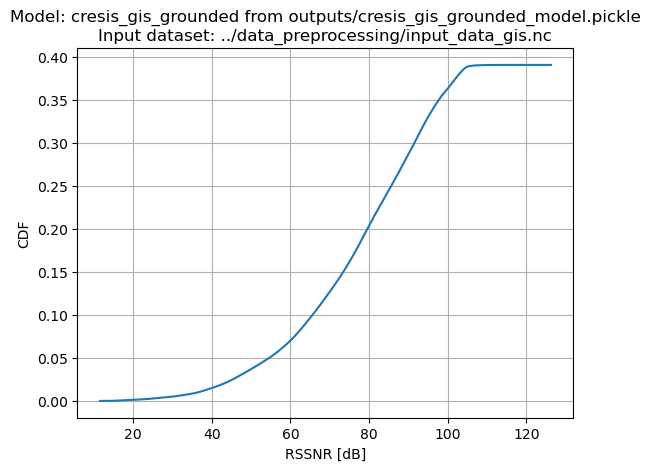

In [12]:
# Create CDF plot of median_rssnr_masked
fig, ax = plt.subplots()

# Import all the variables for each CDF
sorted_median_fast, cdf_values_fast, low_rssnr_fast, high_rssnr_fast = cdf_variable_maker(median_rssnr_fast,
                                                                                          ci_low_rssnr_fast,
                                                                                          ci_high_rssnr_fast
                                                                                         )

sorted_median_slow, cdf_values_slow, low_rssnr_slow, high_rssnr_slow = cdf_variable_maker(median_rssnr_slow,
                                                                                          ci_low_rssnr_slow,
                                                                                          ci_high_rssnr_slow
                                                                                         )

# Plot the fast CDF
ax.plot(sorted_median_fast, cdf_values_fast, color='#db7414')
ax.fill_betweenx(cdf_values_fast, low_rssnr_fast, 
                 high_rssnr_fast, color='#db7414', 
                 label='Fast Ice',
                 alpha=0.25, label='')

# Plot the slow CDF
ax.plot(sorted_median_slow, cdf_values_slow, color='#13679c')
ax.fill_betweenx(cdf_values_slow, low_rssnr_slow, 
                 high_rssnr_slow, color='#13679c', 
                 label='Slow Ice',
                 alpha=0.25, label='')


ax.set_xlabel('RSSNR [dB]')
ax.set_ylabel('CDF')
ax.set_title(f'Model: {training_results["dataset_name"]} from {model_pickle_path}\nInput dataset: {gridded_inputs_path}')
ax.legend()
ax.grid()
plt.show()